# Libararies

In [4]:
# !pip install xgboost

In [23]:
import os
import re
import numpy as np 
from pathlib import Path 
import zipfile
import pandas as pd
import warnings
from random import random
import calendar
import missingno as mn 

import matplotlib.pyplot as plt
import seaborn as sns  
import xgboost as xgb
import lightgbm as lgbm
from pathlib import Path 
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,r2_score,roc_auc_score,precision_score,recall_score,f1_score, classification_report, roc_curve
from sklearn.model_selection import KFold,GridSearchCV,RandomizedSearchCV

from copy import deepcopy 

from sklearn.preprocessing import MinMaxScaler #to normalize data
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import class_weight

from IPython.display import display, Markdown, Image

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Our own libray

In [5]:
current_path = os.getcwd() 
import sys 
sys.path.append(current_path)
current_path = r"c:/classes/pdm/Classes/"
PROJECT_PATH = os.getcwd() + "/gifs" 

sys.path.append(current_path)
from menu_A_a_data_utility import DataUtility  

In [39]:
def load_data(flags = None):
    uti = DataUtility()
    df_train, df_test, df_result = uti.prepare_dfs()
    df_train["rul"] = df_train.groupby(["Flag","id"])["cycle"].transform("max")-df_train["cycle"]
    
    if not flags:
        return df_train, df_test, df_result
    if type(flags) == str:
        flags = [flags] 
    return df_train[df_train["Flag"].isin(flags)],df_test[df_test["Flag"].isin(flags)],df_result[df_result["Flag"].isin(flags)]

DF_TRAIN, DF_TEST, DF_RESULT = load_data(flags = "FD001") 

# Prepare data
id, cycle, Flag and rul are not features

## remove non-feature

In [41]:
df_train = DF_TRAIN.copy()
df_test = DF_TEST.copy()
df_result = DF_RESULT.copy()

cols_to_drop = ['id', 'cycle', 'Flag', 'rul'] 
feats = df_train.columns.drop(cols_to_drop) 

## scale features 

In [42]:
sc = MinMaxScaler(feature_range=(0,1))

df_train[feats] = sc.fit_transform(df_train[feats])
df_test[feats] = sc.transform(df_test[feats])


* use  Trendability <br>
$\begin{equation*}
Trendability \ (x) = | \frac{1}{M} \sum_{j=1}^{M} \ corr(x_j, t_j) |
\end{equation*}$

* define the function

In [48]:
def trendability(col): 
    trend_vals = [] 
    for i in df_train["id"].unique():
        dff = df_train[df_train["id"] == i]
        trend_vals.append(dff[['cycle', col]].corr().iloc[0][1]) 
    return np.abs(np.mean(trend_vals))

trend_df = pd.DataFrame(columns = ['feature', 'trendability_val'])

for col in feats:
    trend_df = trend_df.append({'feature': col, 'trendability_val': trendability(col)}, ignore_index = True)

trend_df = trend_df.sort_values(by = 'trendability_val', ascending = False)
trend_df.head()

,feature,trendability_val
13,sensor11,0.810601
14,sensor12,0.789662
6,sensor4,0.781614
9,sensor7,0.761514
17,sensor15,0.724844


## plot it:

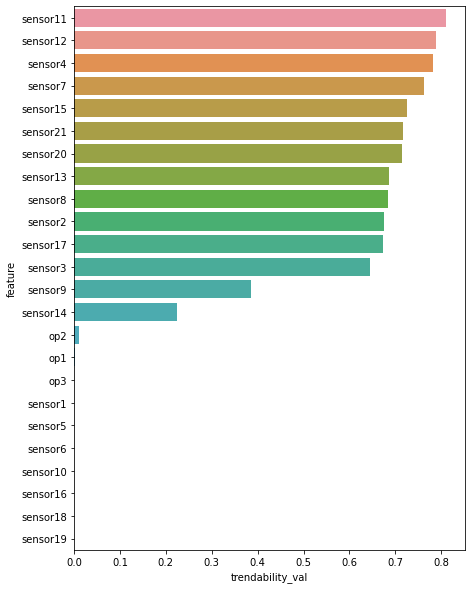

In [50]:
fig, ax = plt.subplots(figsize = (7,10)) 
sns.barplot(y = trend_df.feature, x = trend_df.trendability_val)
plt.show()

## select those with cor > 0.2

In [51]:
feats = trend_df.feature[trend_df.trendability_val > 0.2]
feats

13    sensor11
14    sensor12
6      sensor4
9      sensor7
17    sensor15
23    sensor21
22    sensor20
15    sensor13
10     sensor8
4      sensor2
19    sensor17
5      sensor3
11     sensor9
16    sensor14
Name: feature, dtype: object

# Creating a Linear Degradation model  
* Let's assume health condition of a unit is degrading linearly which can be achieved by rescaling RUL having 1-0 scale

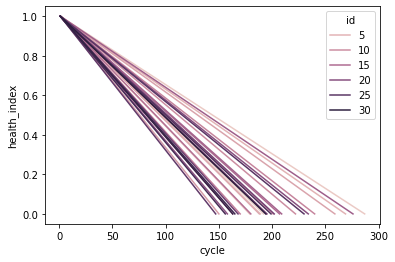

In [57]:
df_train['health_index'] = df_train.groupby('id')['rul'].transform(lambda x: minmax_scale(x))
sns.lineplot(data= df_train[df_train['id'] < 31], x = 'cycle', y = 'health_index', hue= 'id')
plt.show()

# Fiting a linear regression model of health condition with most trended features.

In [65]:
model = LinearRegression()
X = df_train[feats]
y = df_train["health_index"]

model.fit(X,y) 

LinearRegression()

In [66]:
model.coef_, model.intercept_, model.score(X,y)

(array([-0.26884914,  0.24180177, -0.20064758,  0.18905397, -0.12967532,
         0.13174699,  0.13877304, -0.0241087 ,  0.01229191, -0.08003577,
        -0.10509745, -0.09005357, -0.4145927 , -0.27325302]),
 0.6333546734289237,
 0.6520059883900058)

# Constructing a new health indicator by multiplying model coefficient with features

In [68]:
df_train['health_index_final'] = df_train[feats].dot(model.coef_)
df_train["health_index_final"].head()

0    0.087893
1    0.077465
2    0.122410
3    0.200864
4    0.071672
Name: health_index_final, dtype: float64

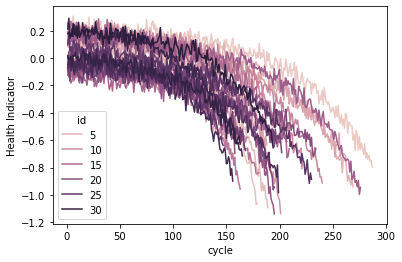

In [71]:
sns.lineplot(data= df_train[df_train['id'] < 31], x = 'cycle', y = 'health_index_final', hue= 'id')
plt.ylabel('Health Indicator')
plt.show()

* Smoothing the final health indicator to reduce noise.

In [73]:
window = 5

df_train_HI = df_train.groupby('id')['health_index_final'].rolling(window = window).mean()
df_train_HI = df_train_HI.reset_index()
df_train_HI.dropna(inplace = True)
df_train_HI.drop(['level_1'], axis = 1, inplace = True)
df_train_HI['cycle'] = df_train_HI.groupby('id').cumcount()+1
df_train_HI.head()

,id,health_index_final,cycle
4,1,0.112061,1
5,1,0.125402,2
6,1,0.133693,3
7,1,0.139125,4
8,1,0.128823,5


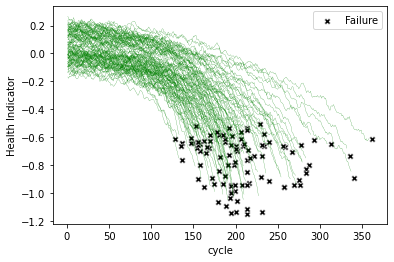

In [75]:
for i in range(1,101):
    sns.lineplot(data= df_train_HI[df_train_HI['id'] == i], x = 'cycle', y = 'health_index_final', color = 'green', lw = 0.2)

sns.scatterplot(data = df_train[df_train.HI == 0], x = 'cycle', y = 'health_index_final', label = 'Failure', 
                marker = 'X', color = 'black')
plt.ylabel('Health Indicator')

plt.show()

## Fitting a second order polynomial function on these health indicators

Fitting a second order polynomial function on these health indicators <br>
$ y = \theta_0 + \theta_1  x + \theta_2  x^2 $

In [77]:
params_df = pd.DataFrame(columns = ['id', 'theta_2', 'theta_1', 'theta_0'])

for i in range(1,101):
    
    y = df_train_HI['health_index_final'][df_train_HI['id'] == i]
    cycle = df_train_HI['cycle'][df_train_HI['id'] == i]

    theta_2, theta_1, theta_0 = np.polyfit(cycle, y, 2)
    
    params_df = params_df.append({'id':i, 'theta_0': theta_0, 'theta_1': theta_1, 'theta_2': theta_2},
                                         ignore_index = True)

## visualize unit 1 

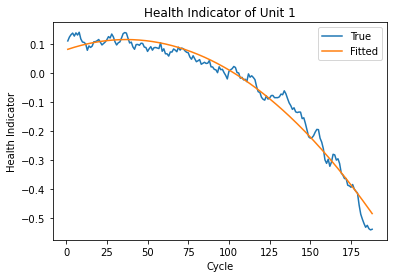

In [79]:
HI = df_train_HI['health_index_final'][df_train_HI['id'] == 1]
cycle = df_train_HI['cycle'][df_train_HI['id'] == 1]

theta_0 = params_df.theta_0[params_df['id'] == 1].values
theta_1 = params_df.theta_1[params_df['id'] == 1].values
theta_2 = params_df.theta_2[params_df['id'] == 1].values

HI_fit = theta_0 + theta_1*cycle + theta_2*cycle*cycle

plt.plot(cycle,HI, label = 'True')
plt.plot(cycle,HI_fit, label = 'Fitted')
plt.ylabel('Health Indicator')
plt.xlabel('Cycle')
plt.legend()
plt.title('Health Indicator of Unit 1');


## visualize all unit

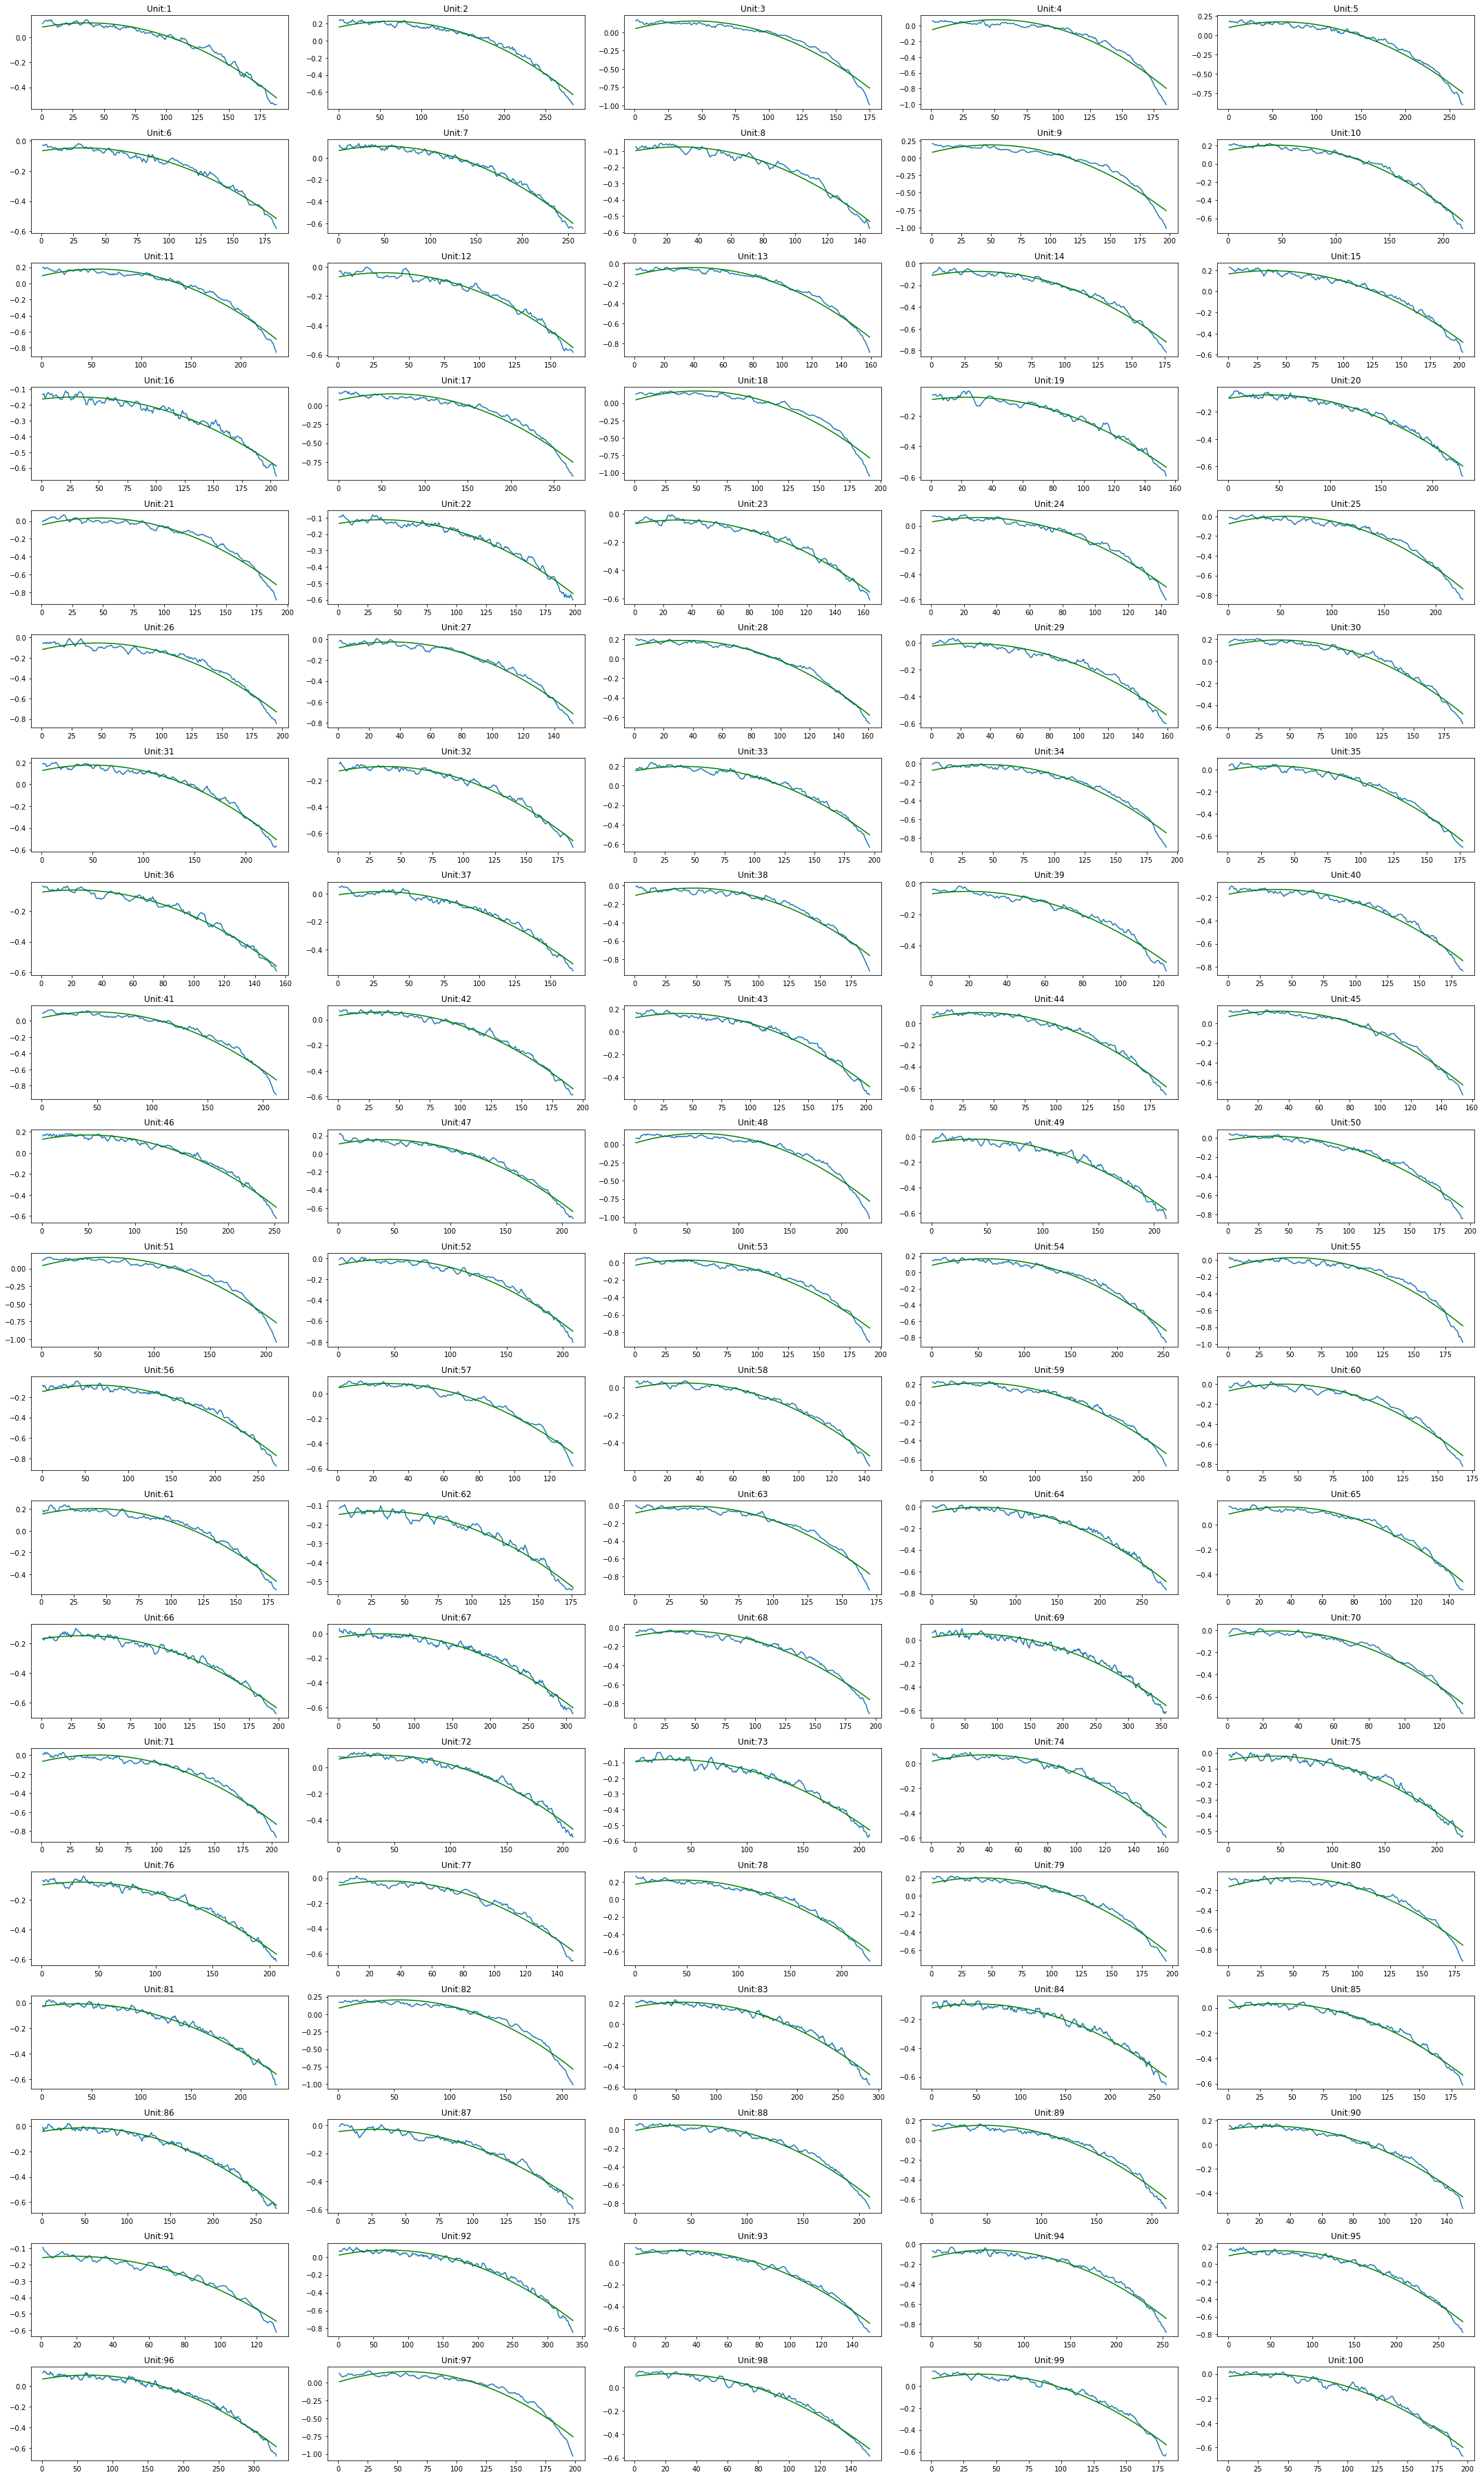

In [81]:
fig, ax = plt.subplots(nrows = 20, ncols = 5, figsize = (30,50))

ax = ax.ravel()

for i in range(0,100):
    
    theta_0 = params_df.theta_0[params_df['id'] == i+1].values
    theta_1 = params_df.theta_1[params_df['id'] == i+1].values
    theta_2 = params_df.theta_2[params_df['id'] == i+1].values
    
    cycle = df_train_HI['cycle'][df_train_HI['id'] == i+1]
    fit_HI = theta_0 + theta_1*cycle + theta_2*cycle*cycle
    
    sns.lineplot(data = df_train_HI[df_train_HI['id'] == i+1], x = "cycle", y = "health_index_final", ax = ax[i])
    sns.lineplot(y = fit_HI, x = cycle, ax = ax[i], color = "green")
    ax[i].set_title("Unit:" + str(i+1))
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")

plt.tight_layout()


# Building a similartiy based RUL model

Steps:

1. Generate a health indicator by multipying weights to selected features in test data
2. Take a rolling mean of Health Indicator to reduce noise
3. Compare the fitted polynomial models with health indicators of test data and find 1-norm residuals using below equation

    $$ d(i,j) = ||y_j - \hat{y_{j,i}} ||_1 $$
    
4. Find similarity score using following formula

    $$ score(i,j) = exp(-d(i,j)^2) $$
   
5. Find top 50 most similar models
6. Find RUL by subtracting current cycle from total cycles of most similar units

## step 1

In [83]:
df_test['health_index_final'] = df_test[feats].dot(model.coef_)
df_test['health_index_final'].head()

0    0.095656
1    0.128882
2    0.051068
3    0.087381
4    0.148141
Name: health_index_final, dtype: float64

## step 2

In [84]:
df_test_HI = df_test.groupby('id')['health_index_final'].rolling(window = window).mean()
df_test_HI = df_test_HI.reset_index()
df_test_HI.dropna(inplace = True)
df_test_HI.drop(['level_1'], axis = 1, inplace = True)
df_test_HI['cycle'] = df_test_HI.groupby('id').cumcount()+1
df_test_HI.head()

,id,health_index_final,cycle
4,1,0.102226,1
5,1,0.110121,2
6,1,0.103964,3
7,1,0.114302,4
8,1,0.115011,5


## step 3/4

In [86]:
df_test_fit = pd.DataFrame(columns = ['id', 'Model', 'Residual', 'similarity', 'total_life'])

for i in df_test_HI['id'].unique():
    
    HI = df_test_HI['health_index_final'][df_test_HI['id'] == i]
    cycle = df_test_HI['cycle'][df_test_HI['id'] == i]
        
    for j in params_df['id'].unique():
        
        theta_0 = params_df.theta_0[params_df['id'] == j].values
        theta_1 = params_df.theta_1[params_df['id'] == j].values
        theta_2 = params_df.theta_2[params_df['id'] == j].values
        
        pred_HI = theta_0 + theta_1*cycle + theta_2*cycle*cycle
        
        Residual = np.mean(np.abs(pred_HI - HI))

        total_life = df_train['cycle'][df_train['id'] == j].max()
        
        similarity_score = np.exp(-Residual*Residual)
        
        df_test_fit = df_test_fit.append({'id':i, 'Model': j, 'Residual': Residual, 
                                          'similarity': similarity_score, 'total_life': total_life},
                                         ignore_index = True)

        

In [87]:
df_test_fit.head()

,id,Model,Residual,similarity,total_life
0,1.0,1.0,0.018282,0.999666,192.0
1,1.0,2.0,0.072895,0.9947,287.0
2,1.0,3.0,0.031416,0.999014,179.0
3,1.0,4.0,0.104821,0.989073,189.0
4,1.0,5.0,0.024883,0.999381,269.0


## step 5/6 
*Selecting 5 most similar units*

In [ ]:
ind_5 = df_test_fit.groupby('id')['similarity'].nlargest(5).reset_index()['level_1']
result_df_5 = df_test_fit.iloc[ind_5]
result_df_5.head()


In [ ]:
len(result_df_50)

* Visualizing 5 most similar units to unit 5 of test data

In [ ]:
dff = result_df_50[result_df_50['id'] == 3]

for i in dff.Model.unique():
    sns.lineplot(data= df_train_HI[df_train_HI['id'] == i], x = 'cycle', y = 'health_index_final', color = 'green', lw = 0.2)
    sns.scatterplot(data = df_train[(df_train_HI['id'] == i) & (df_train.HI == 0)], x = 'cycle', y = 'health_index_final', 
                    marker = 'X', color = 'black')

sns.lineplot(data= df_test_HI[df_test_HI['id'] == 5], x = 'cycle', y = 'health_index_final', color = 'red', 
             label = 'Test Unit')
plt.ylabel('Health Indicator')
plt.title('5 Nearest neighbors of Test Unit 5');

## step 7

In [ ]:
y_true_5 = y_true.copy()

y_true_5['Pred_RUL'] = (result_df_5.groupby('id')['total_life'].mean() - df_test.groupby('id')['cycle'].max()).values
y_true_5.head()


## results

In [ ]:
sns.regplot(x = y_true_50.Pred_RUL, y = y_true_50.RUL)
plt.xlabel('Predicted RUL')
plt.ylabel('True RUL')

In [ ]:
fig, ax = plt.subplots(figsize = (15, 7))
sns.lineplot(x = y_true_50['id'], y = y_true_50.Pred_RUL, label = "Predicted RUL")
sns.lineplot(x = y_true_50['id'], y = y_true_50.RUL, label = "True RUL")
plt.xlabel("Unit Number")
plt.ylabel("Remaining Useful Life")
plt.legend(loc = 1)

## metrics

In [ ]:
mean_squared_error(y_true_5.RUL, y_true_5.Pred_RUL)

In [ ]:
mean_absolute_error(y_true_5.RUL, y_true_5.Pred_RUL)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mean_absolute_percentage_error(y_true_5.RUL, y_true_5.Pred_RUL)

# Data Check

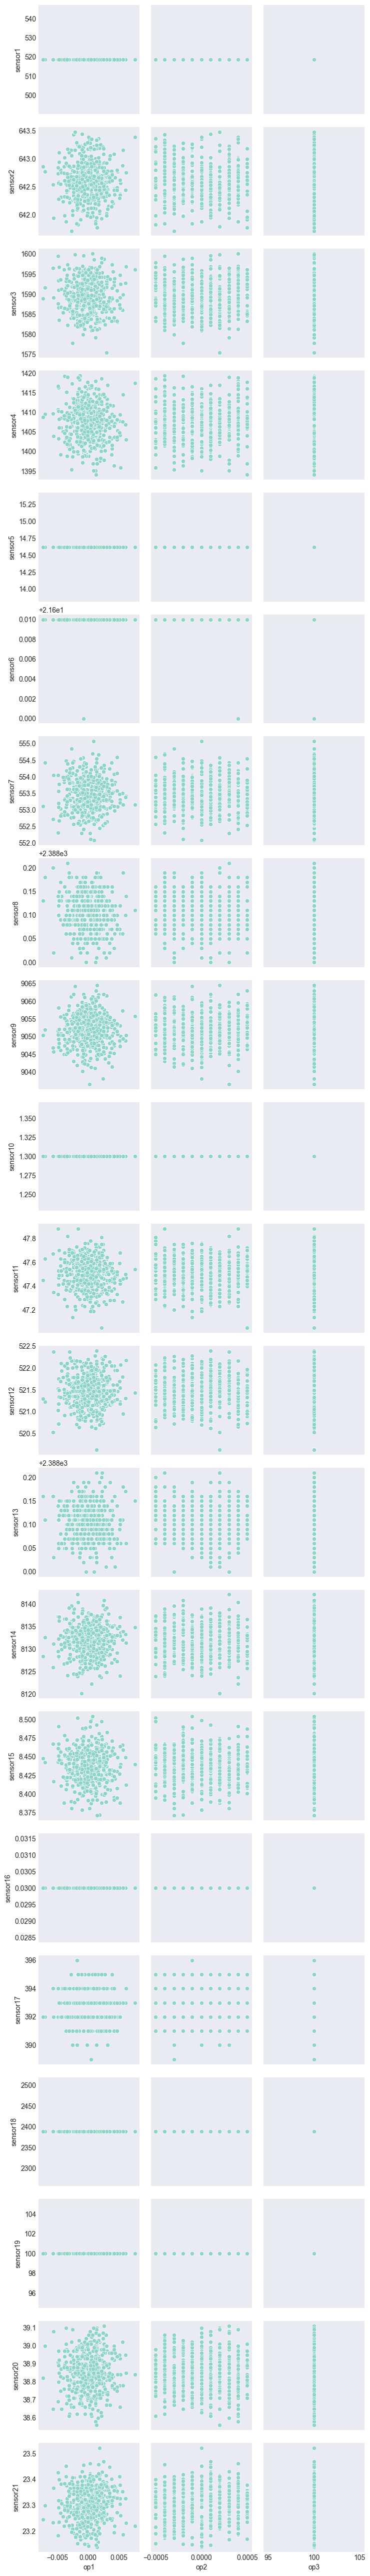

In [186]:
plt.style.use('seaborn-dark')

op_set=["op"+str(i) for i in range(1,4)]
sensor=["sensor"+str(i) for i in range(1,22)]

ax=sb.pairplot(df_test.query("cycle"),x_vars=op_set,y_vars=sensor,palette="husl")